# **CBIR Theory**

Content-Based Image Retrieval (CBIR) is a method for retrieving photos from a database based on the content of the images. It analyzes visual features like shapes, colors, textures, and spatial information to identify similarities between a query image and images in the database. CBIR falls into two primary categories: text-based and content-based image retrieval systems. Text-based systems use tags or keywords to index and search images, while content-based systems analyze the actual content of images, extracting characteristics such as color, texture, and shape for efficient access. Content-based systems employ methods like edge detection, color histograms, and deep learning to compare and retrieve images with similar visual content when a user enters a query image.

# **Color Histograms**
A color histogram is a representation of the distribution of colors in an image. It quantizes the color space into bins and counts the number of pixels that fall into each bin. The resulting histogram provides information about the frequency of different color intensities in the image.

# **Color Moments**
Color moments are statistical measures that describe the distribution of colors in an image. They provide a more detailed analysis of color information compared to histograms.

# **Instructions to the required files**

1.   The Dataset should be a folder named Dataset, divided into categories, each category should be named. The number of images per category should be the same or you will get incorrect results. Each image should be named with a number, 345.jpg for example, different from any other image, and should be in the range of 0 to (number of images - 1). The dataset used in making this project is: https://www.kaggle.com/datasets/ambarish/wangdataset
2.   The Queries folder contains the images to be searched for. The naming of each image must be like the following: query_i_Categry.jpg. For example, query_0_Horses.jpg. The number i must fall in the range of 0 to (number of queries - 1) and the Category must belong to one of the categories in the dataset.

3.   Compress the 2 folders and upload them as a zip file to the content directory in colab.



# Task 1: Implementing the system using Color Histograms

In [ ]:
import os
import cv2
import time
import zipfile
import tabulate
import numpy as np
import seaborn as sns
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from keras.applications.vgg16 import VGG16
from scipy.stats import skew, mode, kurtosis
from keras.preprocessing import image as imaging
from keras.applications.vgg16 import preprocess_input

Extracting the dataset and the queries.

In [ ]:
dataset_zip_path = '/content/Dataset.zip'
queries_zip_path = '/content/Queries.zip'
extraction_path = '/content'

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

with zipfile.ZipFile(queries_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

dataset_path = '/content/Dataset'
query_path = '/content/Queries'
len_queries = len(os.listdir(query_path))
len_dataset = 0
number_of_categories = 0
must_be = -1

for category in os.listdir(dataset_path):
    number_of_categories += 1
    category_path = os.path.join(dataset_path, category)
    len_dataset += len(os.listdir(category_path))
    if must_be == -1:
        must_be = len(os.listdir(category_path))
    else:
        assert must_be == len(os.listdir(category_path))

all_data_list = [None] * (len_queries + len_dataset)
photos_per_category = len_dataset / number_of_categories

This function extracts the color features (histogram) for each color channel from the RGB individually, normalizes the vectors and then concatinates them together. This will be the histogram representation for each image. This function also indexes the histograms of the images in the all_data_list list. The bins here refers to the number of bins or buckets that are used to divide the range of pixel intensities in the image. And the range [0, 256] represents the range of pixel values.

In [ ]:
def extract_color_features(image_path, bins, idx):
    image = cv2.imread(image_path)
    all_data_list[idx] = image
    hist_blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    hist_green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    hist_red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    cv2.normalize(hist_blue, hist_blue, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist_green, hist_green, 0, 1, cv2.NORM_MINMAX)
    cv2.normalize(hist_red, hist_red, 0, 1, cv2.NORM_MINMAX)
    hist = np.concatenate((hist_red, hist_green, hist_blue), axis=None)
    return hist

This function stores the histograms for each image from the dataset.

In [ ]:
def compute_histograms(dataset_path, bins):
    category_histograms = {}
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        category_histograms[category] = []

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            idx = int(image_name.split('.')[0]) + len_queries
            features = extract_color_features(image_path, bins, idx)
            category_histograms[category].append({'image_name': image_name, 'features': features})

    return category_histograms

This function stores the histograms for each image from the queries.

In [ ]:
def compute_query_histograms(query_path, bins):
    query_histograms = []
    for query_name in os.listdir(query_path):
        query_image_path = os.path.join(query_path, query_name)
        idx = int(query_name.split('_')[1])
        features = extract_color_features(query_image_path, bins, idx)
        query_histograms.append({'query_name': query_name, 'features': features})

    return query_histograms

This function finds the distances between each query and all of the dataset using the euclidean distance. If the distance is less than or equal to the threshold, then this image is considered similar to the query and added to its results. Then the results of the current query is sorted based on the distance, least first, and the matches for all queries are returned.

In [ ]:
def find_matches_below_threshold(query_histograms, category_histograms, threshold):
    all_matches = {}

    for query in query_histograms:
        query_name = query['query_name']
        query_features = query['features']

        all_category_matches = []
        for category, histograms in category_histograms.items():
            for histogram in histograms:
                image_name = histogram['image_name']
                features = histogram['features']
                distance = np.linalg.norm(query_features - features)
                if distance <= threshold:
                    all_category_matches.append({'category': category, 'image_name': image_name, 'distance': distance})
        all_matches[query_name] = sorted(all_category_matches, key=lambda x: x['distance'])
    return all_matches

This function plots the top 7 results for a set of queries.

In [ ]:
def plot_top_results(matches_below_threshold, query, bins = -1, num_to_print = 7):
    plt.figure(figsize=(20, 5))
    category = query.split('_')[-1].split('.')[0]
    title = f'Top {min(num_to_print, len(matches_below_threshold))} Results for {category} Queries'
    if bins != -1:
        title = title + f' with bins = {bins}'
    plt.suptitle(title)
    plt.subplot(1, num_to_print + 1, 1)
    plt.title(f'Query: {query}')
    idx_query = int(query.split('_')[1])
    plt.imshow(cv2.cvtColor(all_data_list[idx_query], cv2.COLOR_BGR2RGB))
    plt.axis('off')

    j = 0
    for result in matches_below_threshold:
        image_name = result['image_name']
        category_res = result['category']
        idx_img = int(image_name.split('.')[0]) + len_queries
        plt.subplot(1, num_to_print + 1, j + 2)
        plt.title(f'{category_res}: {image_name}')
        plt.imshow(cv2.cvtColor(all_data_list[idx_img], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        j += 1
        if j == min(num_to_print, len(matches_below_threshold)):
          break
    plt.show()

This is the function that is responsible of calculting the metrics and plotting the ROC curve for the results.

Lets process the logic behind this code:

1. To plot the ROC curve, we need to have data from the true positive rates (TPR) and the false pisitive rates (FPR).

2. To get this data, we will apply different thresholds, for each threshold we will calculate a point on the curve.

3. The range of the thresholds was chosen based on the minimum and maximum distances between the queries and the dataset.

4. For each threshold, we calculate the true positives, false positives, true negatives, and false negatives among all queries and then take their average.

* The true positives are the images retrieved and relevant to the query.

* The false positives are the images retrieved but are not relevant.

* The false negatives are are the ones that are not retrieved but they are relevant.

* The true negatives are the ones not retrieved and not relevant.

5. So for each query, we count the number of true positives (tp), which is the number of correctly predicted images. the false positives will be the remaining images from the predictions (len(predicted_categories) - tp). The false negatives are the true images not predicted, which are all the images in the true category but the ones retrieved (photos_per_category - tp). The false negatives are everything else but the ones calculated (len_dataset - ((tp) + (len(predicted_categories) - tp) + (photos_per_category - tp))).

6. After calculating these metrics, we will take the average of them among all queries. We calculate the precision, recall, F1 score, TPR, and FPR. Then we take the point on the curve.

In [ ]:
def compute_roc_curve(query_histograms, category_histograms, bins, start):
    all_matches = {}
    true_positive_rates = []
    false_positive_rates = []
    iter = 0

    for threshold in np.arange(0, 30, 30 / 300):
        matches_below_threshold = find_matches_below_threshold(query_histograms, category_histograms, threshold)

        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0
        iter += 1

        for query_name, matches in matches_below_threshold.items():
            ground_truth_category = query_name.split('_')[-1].split('.')[0]
            predicted_categories = [match['category'] for match in matches]
            tp = 0
            for predicted_category in predicted_categories:
                if predicted_category == ground_truth_category:
                    tp += 1

            true_positives += tp
            false_positives += len(predicted_categories) - tp
            false_negatives += photos_per_category - tp
            true_negatives += len_dataset - (tp + len(predicted_categories) - tp + photos_per_category - tp)

        true_positives = true_positives // len_queries
        false_positives = false_positives // len_queries
        true_negatives = true_negatives // len_queries
        false_negatives = false_negatives // len_queries

        assert false_positives + true_negatives > 0
        assert true_positives + false_positives > 0
        assert true_positives + false_negatives > 0

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        assert precision + recall > 0
        F1_score = 2 * precision * recall / (precision + recall)
        TPR = recall
        FPR = false_positives / (false_positives + true_negatives)
        true_positive_rates.append(TPR)
        false_positive_rates.append(FPR)

        if iter == 90:
          categories_to_plot = ['Buses', 'Buildings', 'Dinosaurs']
          for query in os.listdir(query_path):
            category = query.split('_')[-1].split('.')[0]
            if category in categories_to_plot:
              plot_top_results(matches_below_threshold[query], query, bins)

          # Confusion matrix data
          matrix_data = [[true_negatives, false_positives], [false_negatives, true_positives]]

          # Metrics data
          metrics_labels = ['Precision', 'Recall', 'F1 Score', 'Threshold']
          metrics_values = [precision, recall, F1_score, threshold]

          # Plotting confusion matrix and evaluation metrics as heatmaps
          plt.figure(figsize=(12, 6))

          # Confusion Matrix
          plt.subplot(1, 2, 1)
          class_labels = ['Negative', 'Positive']
          class_labels2 = ['False', 'True']
          sns.heatmap(matrix_data, annot=True, fmt="f", cmap="Blues", xticklabels=class_labels2, yticklabels=class_labels)
          plt.xlabel('Predicted Label')
          plt.ylabel('True Label')
          plt.title('Confusion Matrix')

          # Metrics Table
          plt.subplot(1, 2, 2)
          table_data = [[label, value] for label, value in zip(metrics_labels, metrics_values)]
          table = plt.table(cellText=table_data, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')
          table.auto_set_font_size(False)
          table.set_fontsize(10)
          table.scale(1, 1.5)
          plt.axis('off')
          plt.title('Evaluation Metrics')

          plt.tight_layout()
          plt.show()

    end = time.time()
    time_str = f'Time: {(end - start):.2f} seconds'
    return false_positive_rates, true_positive_rates, time_str

Processing the data on different bins.

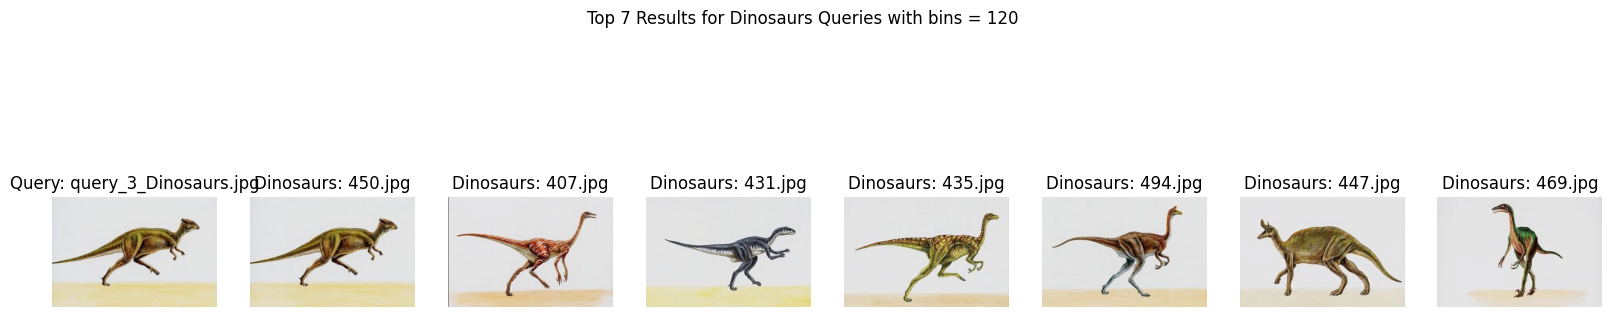

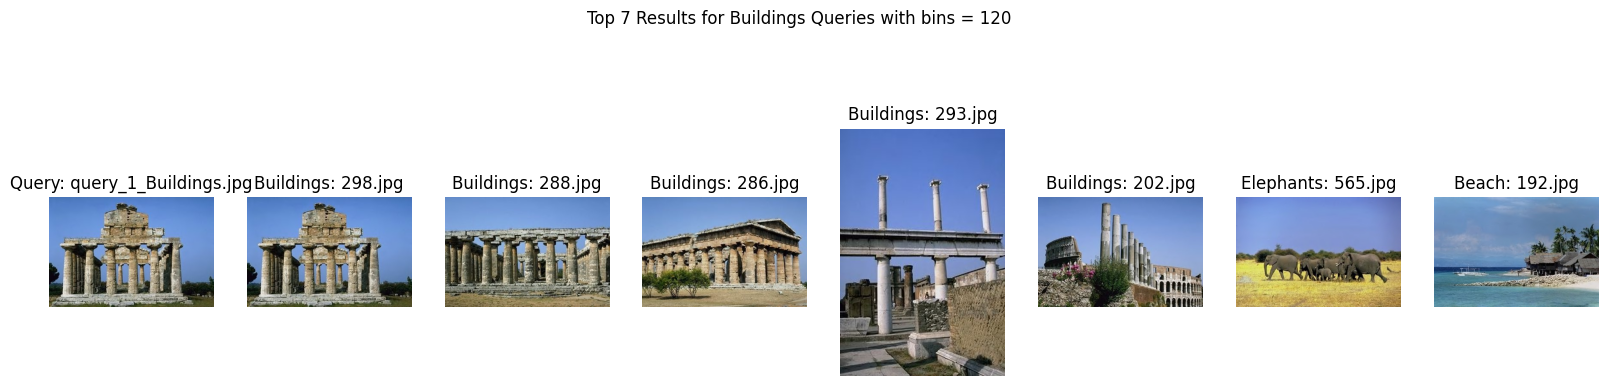

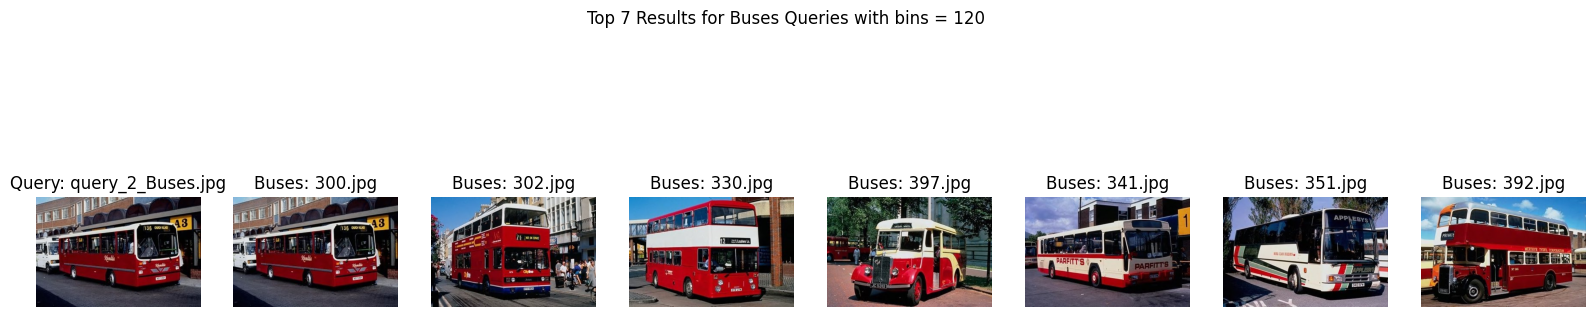

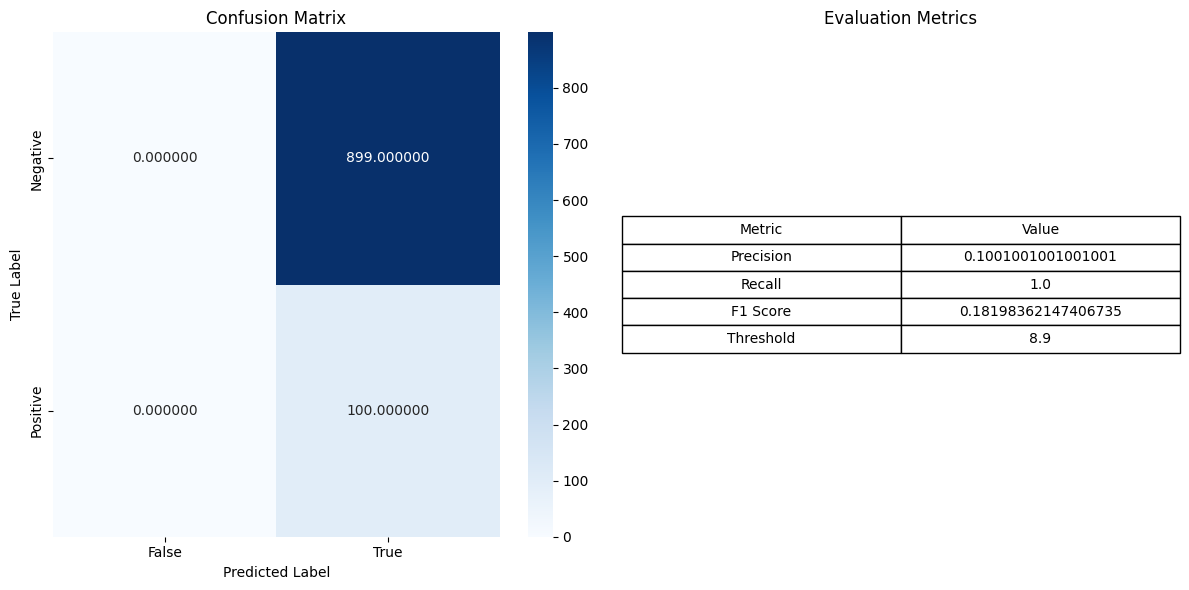

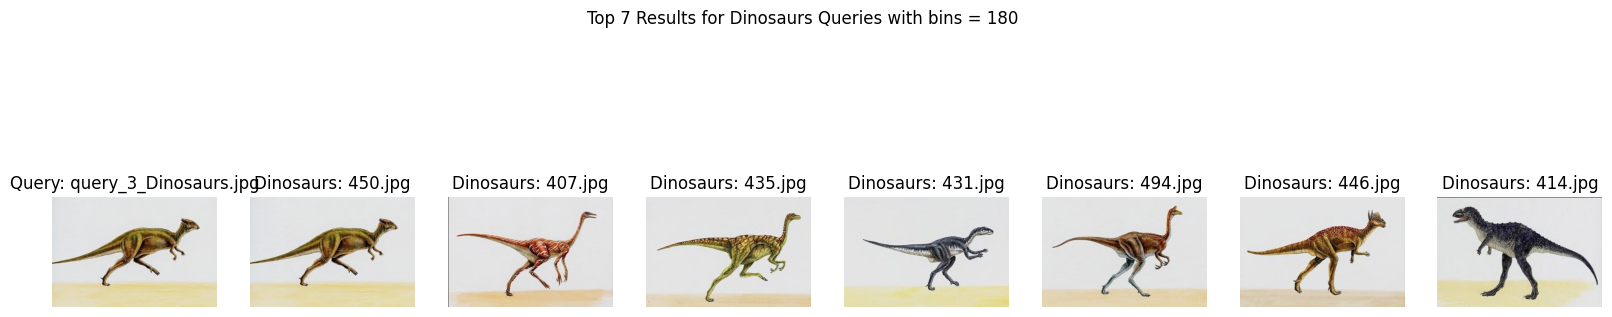

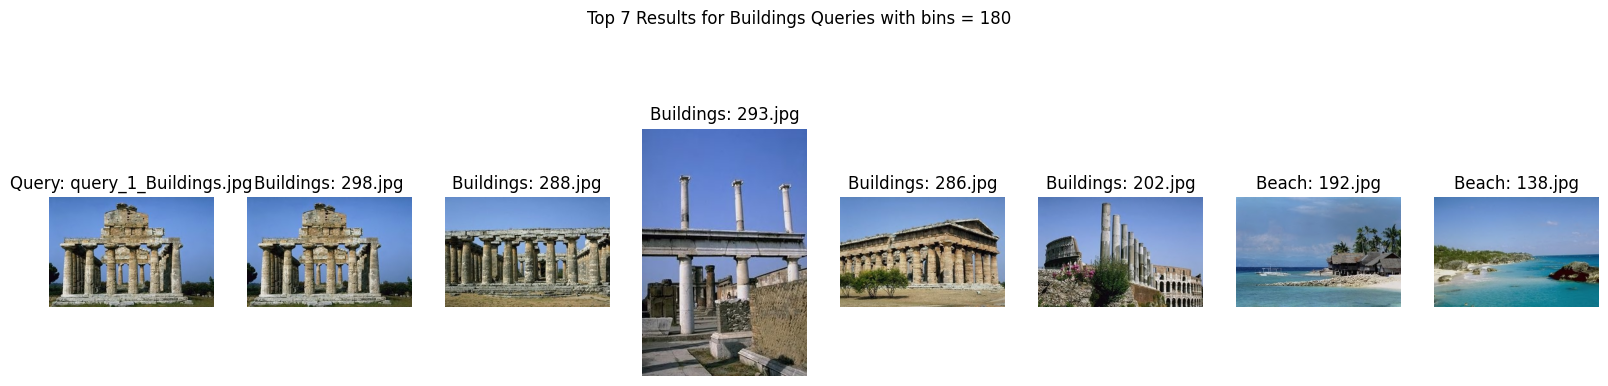

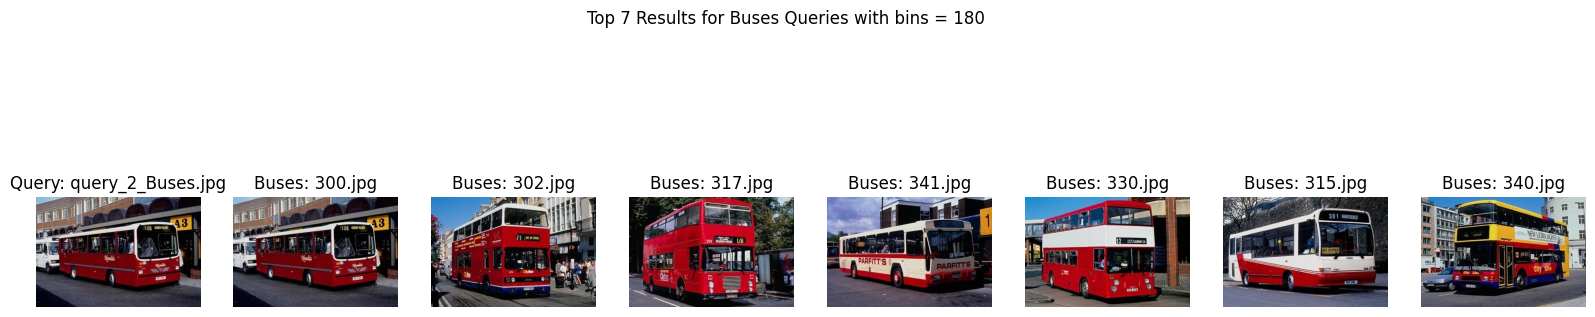

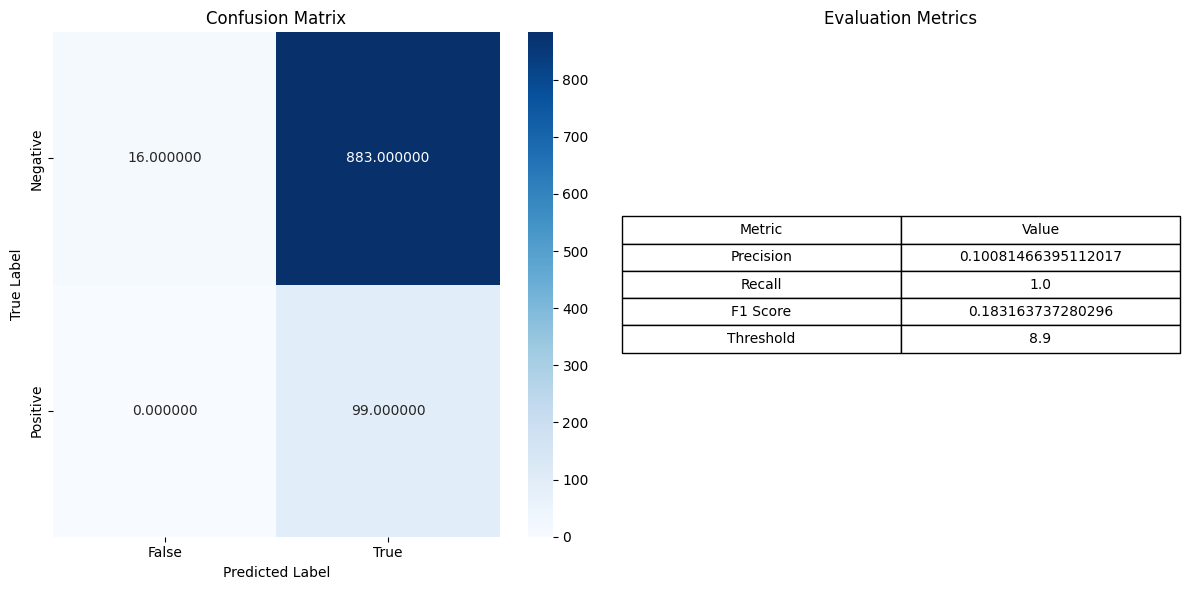

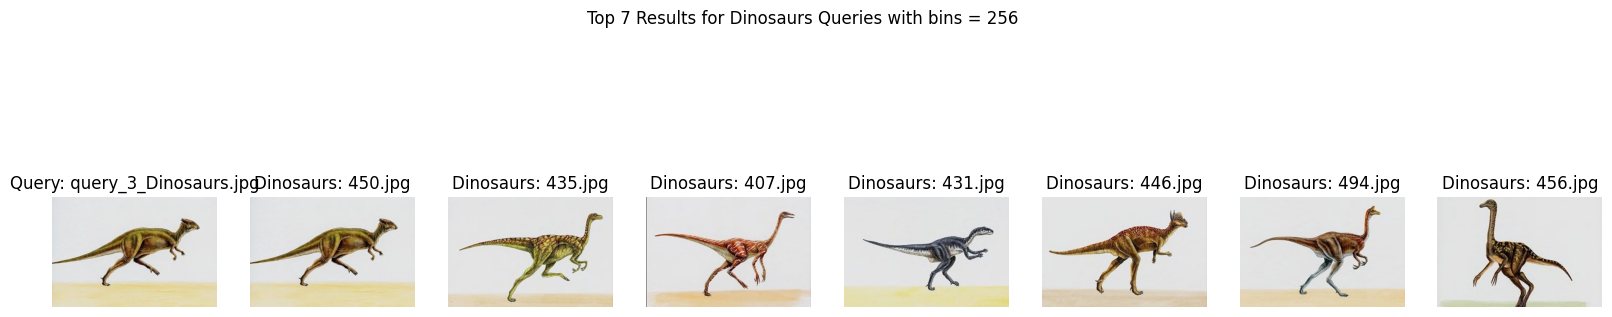

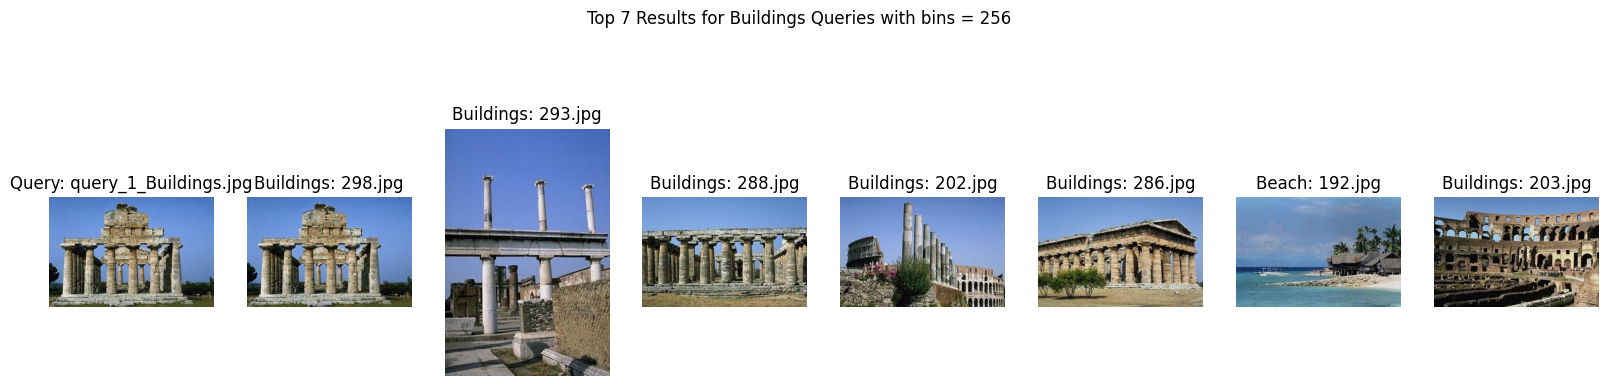

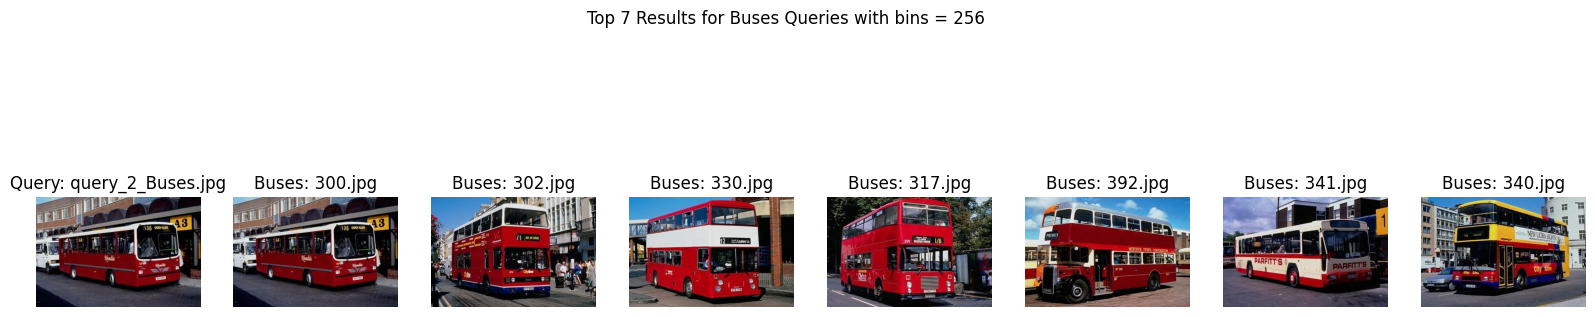

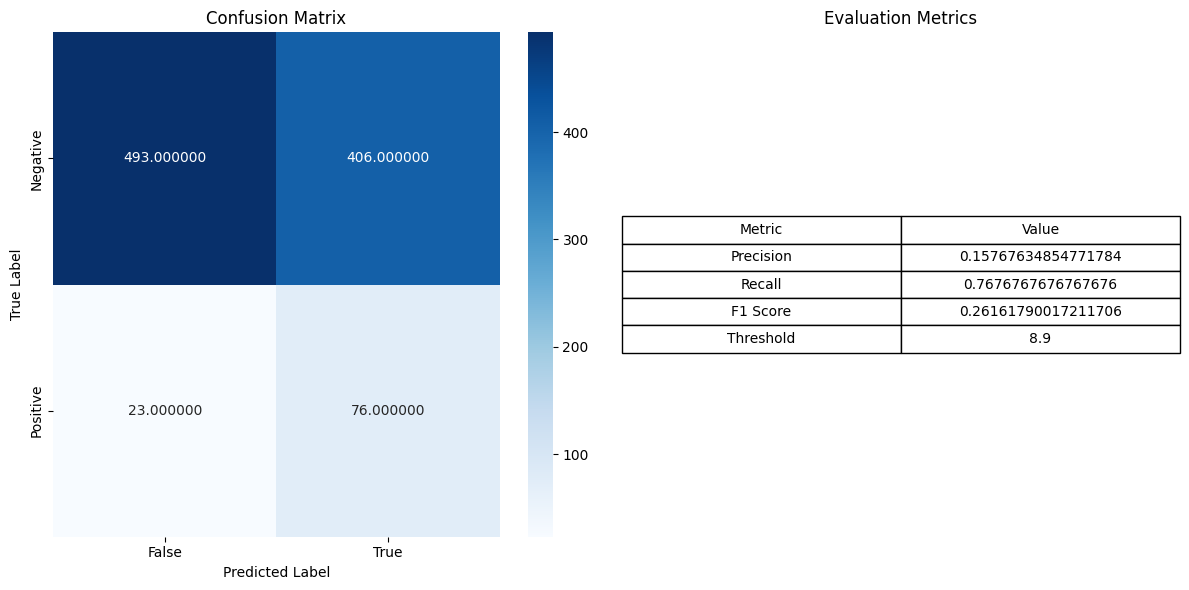

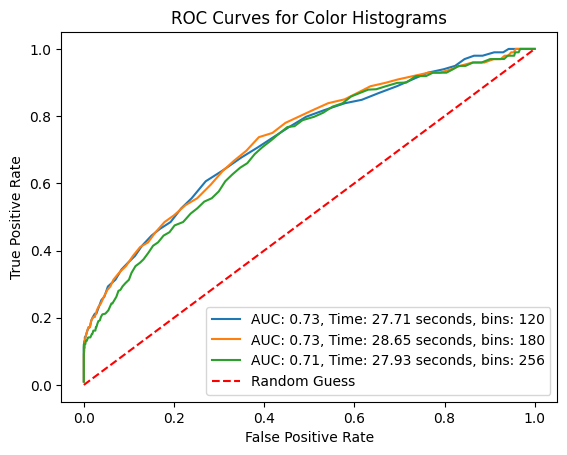

In [ ]:
bins_vals = [120, 180, 256]
results = []

for bins in bins_vals:
    start = time.time()
    query_histograms = compute_query_histograms(query_path, bins)

    category_histograms = compute_histograms(dataset_path, bins)

    false_positive_rates, true_positive_rates, time_str = compute_roc_curve(query_histograms, category_histograms, bins, start)
    results.append({'TPR': true_positive_rates, 'FPR': false_positive_rates, 'time': time_str, 'bins': bins})

for result in results:
    tpr = result['TPR']
    fpr = result['FPR']
    time_str = result['time']
    bins = result['bins']

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC: {roc_auc:.2f}, {time_str}, bins: {bins}')


plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Color Histograms')
plt.legend(loc='lower right')
plt.show()

Key Metrics:

* Precision: 0.15 (15%)

* Recall: 0.76 (76%)

* F1-score: 0.26 (26%)

AUC (for different bin configurations):
* Bins = 120: 0.73

* Bins = 180: 0.73

* Bins = 256: 0.71

From the results above, we can see that:

* High Recall, Low Precision: The system is successfully retrieving a large proportion of relevant images (76% recall), but with a high number of false positives (precision of 15%). This suggests the system is sensitive but not very specific.

* Low F1-score: The F1-score, a harmonic mean of precision and recall, is relatively low at 0.26. This indicates a need to improve the balance between precision and recall.

* AUC Scores: The AUC scores, ranging from 0.71 to 0.73, suggest reasonable performance in distinguishing relevant from irrelevant images across different bin configurations.

* Threshold Trade-offs: The chosen threshold likely prioritizes recall over precision. Experimenting with different thresholds could potentially improve precision at the expense of some recall.

* Bin Configuration Impact: The AUC scores indicate that the choice of bin configuration (120 or 180) has minimal impact on performance, while a higher number of bins (256) might slightly decrease performance.

# Task 2: Implementing the system using Color Moments

This function extracts the features of the image using color moments (mean, standard deviation, skewness, median, mode, kurtosis). The main ones (mean, std, skewness) are calculated for the features array, but the rest of them are calculated only if more_features boolean is true. The features are calculated by splitting the channels and calculating for each channel of the RGB.

In [ ]:
def extract_color_features_moments(idx, more_features = False):
    image = all_data_list[idx]
    blue, green, red = cv2.split(image)

    red_mean = np.mean(red)
    green_mean = np.mean(green)
    blue_mean = np.mean(blue)

    red_std = np.std(red)
    green_std = np.std(green)
    blue_std = np.std(blue)

    red_skew = skew(red.flatten())
    green_skew = skew(green.flatten())
    blue_skew = skew(blue.flatten())

    blue_median = np.median(blue) if more_features else 0
    green_median = np.median(green) if more_features else 0
    red_median = np.median(red) if more_features else 0

    blue_mode = mode(blue).mode[0] if more_features else 0
    green_mode = mode(green).mode[0] if more_features else 0
    red_mode = mode(red).mode[0] if more_features else 0

    blue_kurtosis = kurtosis(blue.flatten()) if more_features else 0
    green_kurtosis = kurtosis(green.flatten()) if more_features else 0
    red_kurtosis = kurtosis(red.flatten()) if more_features else 0

    array = np.array([[red_mean, red_std, red_skew, red_median, red_mode, red_kurtosis],
                      [green_mean, green_std, green_skew, green_median, green_mode, green_kurtosis],
                      [blue_mean, blue_std, blue_skew, blue_median, blue_mode, blue_kurtosis]])


    return array

This function is the same as the one in color histograms, calculates the moments for all dataset images.

In [ ]:
def compute_histograms_moments(dataset_path, more_featrues = False):
    category_histograms = {}
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        category_histograms[category] = []

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            idx = int(image_name.split('.')[0]) + len_queries
            features = extract_color_features_moments(idx, more_featrues)
            category_histograms[category].append({'image_name': image_name, 'features': features})

    return category_histograms

This function is the same as the one in color histograms, calculates the moments for all queries.

In [ ]:
def compute_query_histograms_moments(query_path, more_featrues = False):
    query_histograms = []
    for query_name in os.listdir(query_path):
        query_image_path = os.path.join(query_path, query_name)
        idx = int(query_name.split('_')[1])
        features = extract_color_features_moments(idx, more_featrues)
        query_histograms.append({'query_name': query_name, 'features': features})

    return query_histograms

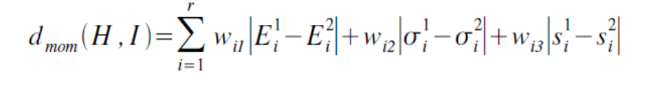

This equation is used to calculate the distance between two images, where:

* H, I are the images.
* i is the current channel index.
* r is the number of channels (r = 3).
* $E_i^1, E_i^2$ are the first moments (means) of the two images.
* $\sigma_i^1, \sigma_i^2$ are the second moments (standard deviation) of the two images.
* $S_i^1, S_i^2$ are the third moments (skewness) of the two images.
* $w_i$ are the weights for each moment.
* If more features are added, they will be accumulated to the three above.
* The lower distance, the higher ranking.

In [ ]:
def find_matches_below_threshold_moments(query_histograms, category_histograms, threshold, w = np.ones((3, 6))):
    all_matches = {}

    for query in query_histograms:
        query_name = query['query_name']
        query_features = query['features']

        all_category_matches = []
        for category, histograms in category_histograms.items():
            for histogram in histograms:
                image_name = histogram['image_name']
                data_features = histogram['features']
                distance = 0
                for i in range(3):
                    for j in range(6):
                      distance += w[i][j] * abs(query_features[i][j] - data_features[i][j])
                if distance <= threshold:
                    all_category_matches.append({'category': category, 'image_name': image_name, 'distance': distance})

        all_matches[query_name] = sorted(all_category_matches, key=lambda x: x['distance'])
    return all_matches

This function computes the ROC Curve for the Color Moments System. We added the weights array so that we can control what we want to prioritize over the moments. The rest of the calculations is done as in the color histogram system.

In [ ]:
def compute_roc_curve_moments(query_histograms, category_histograms, start,  w = np.ones((3, 6))):
    all_matches = {}
    true_positive_rates = []
    false_positive_rates = []
    iter = 0

    for threshold in np.arange(0, 2000, 20):
        matches_below_threshold = find_matches_below_threshold_moments(query_histograms, category_histograms, threshold, w)

        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0
        iter += 1

        for query_name, matches in matches_below_threshold.items():
            ground_truth_category = query_name.split('_')[-1].split('.')[0]
            predicted_categories = [match['category'] for match in matches]
            tp = 0
            for predicted_category in predicted_categories:
                if predicted_category == ground_truth_category:
                    tp += 1

            true_positives += tp
            false_positives += len(predicted_categories) - tp
            false_negatives += photos_per_category - tp
            true_negatives += len_dataset - (tp + len(predicted_categories) - tp + photos_per_category - tp)

        true_positives = true_positives // len_queries
        false_positives = false_positives // len_queries
        true_negatives = true_negatives // len_queries
        false_negatives = false_negatives // len_queries

        assert false_positives + true_negatives > 0
        assert true_positives + false_positives > 0
        assert true_positives + false_negatives > 0

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        assert precision + recall > 0
        F1_score = 2 * precision * recall / (precision + recall)
        TPR = recall
        FPR = false_positives / (false_positives + true_negatives)
        true_positive_rates.append(TPR)
        false_positive_rates.append(FPR)

        if iter == 50:
          categories_to_plot = ['Nature', 'Buildings', 'Dinosaurs']
          for query in os.listdir(query_path):
            category = query.split('_')[-1].split('.')[0]
            if category in categories_to_plot:
              plot_top_results(matches_below_threshold[query], query)

          # Confusion matrix data
          matrix_data = [[true_negatives, false_positives], [false_negatives, true_positives]]

          # Metrics data
          metrics_labels = ['Precision', 'Recall', 'F1 Score', 'Threshold']
          metrics_values = [precision, recall, F1_score, threshold]

          # Plotting confusion matrix and evaluation metrics as heatmaps
          plt.figure(figsize=(12, 6))

          # Confusion Matrix
          plt.subplot(1, 2, 1)
          class_labels = ['Negative', 'Positive']
          class_labels2 = ['False', 'True']
          sns.heatmap(matrix_data, annot=True, fmt="f", cmap="Blues", xticklabels=class_labels2, yticklabels=class_labels)
          plt.xlabel('Predicted Label')
          plt.ylabel('True Label')
          plt.title('Confusion Matrix')

          # Metrics Table
          plt.subplot(1, 2, 2)
          table_data = [[label, value] for label, value in zip(metrics_labels, metrics_values)]
          table = plt.table(cellText=table_data, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')
          table.auto_set_font_size(False)
          table.set_fontsize(10)
          table.scale(1, 1.5)
          plt.axis('off')
          plt.title('Evaluation Metrics')

          plt.tight_layout()
          plt.show()


    roc_auc = auc(false_positive_rates, true_positive_rates)
    plt.plot(false_positive_rates, true_positive_rates, label=f'ROC Curve, AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    end = time.time()
    time_str = f'Time taken = {(end - start):.2f} seconds'
    plt.plot([], [], ' ', label=time_str)  # Create an empty plot for the time legend entry

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')
    plt.legend()
    plt.show()
    return all_matches

If you want to run the code with adding more moments, more_featrues must be true, and you can adjust the weights as you like.

You can adhust the weights without adding more_features, but the last 3 values in each row wont matter because more_features is False and it wont calculate their features, so they will be 0.

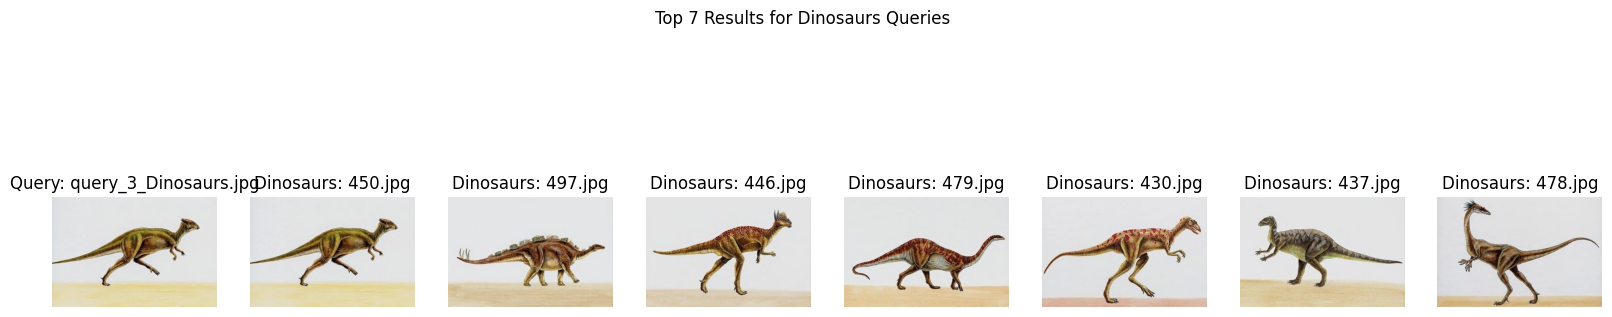

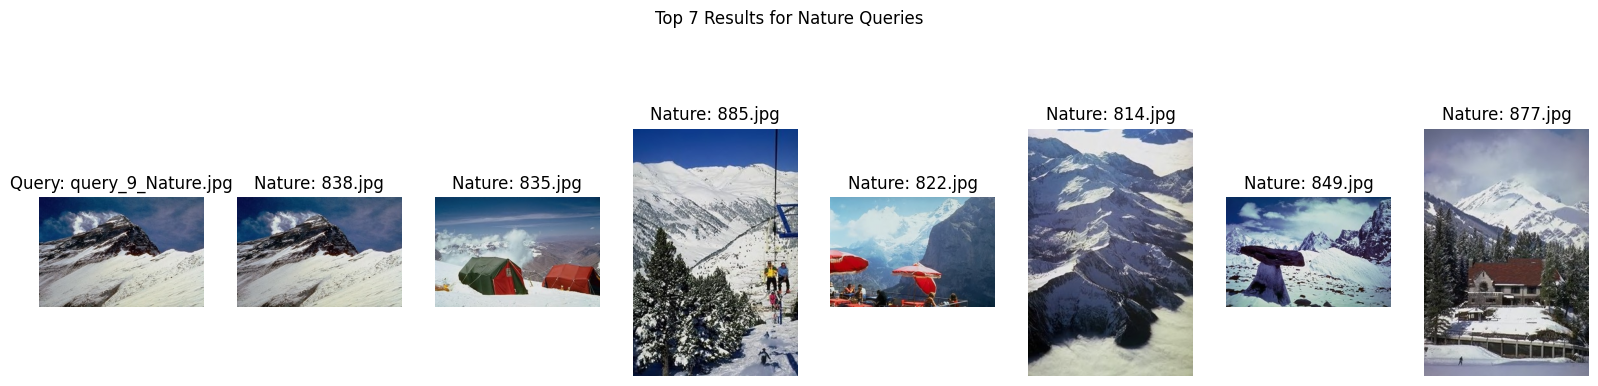

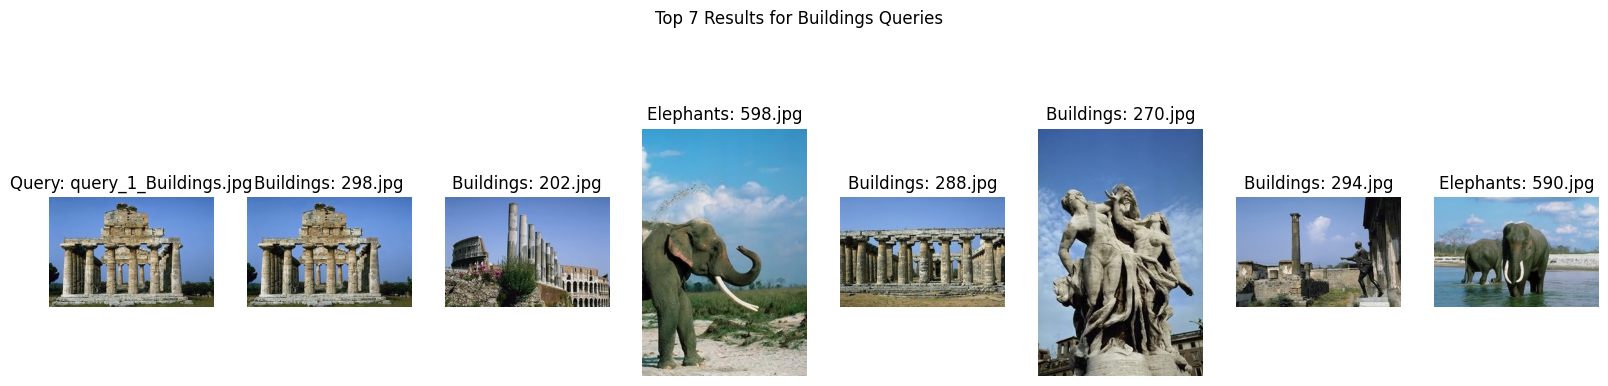

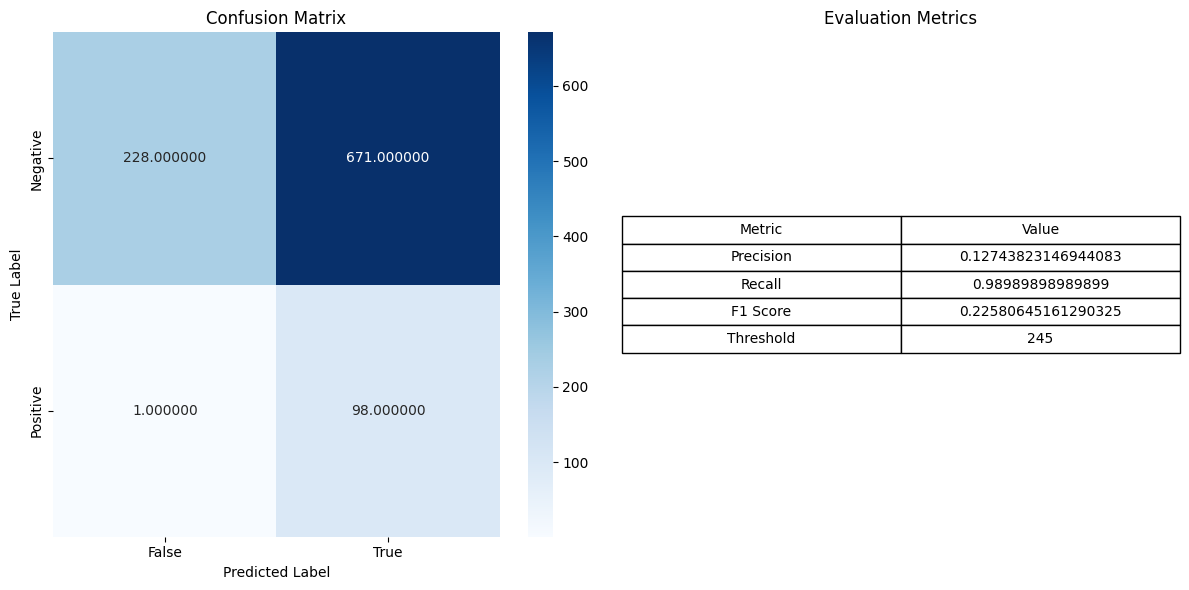

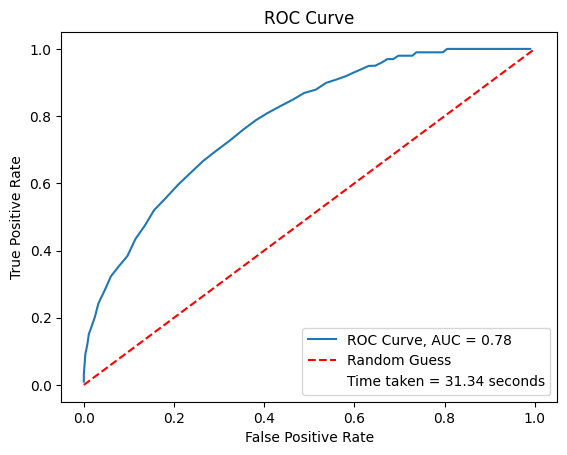

In [ ]:
more_featrues = False # This will eliminate the ones in the weights array since the new features' values will be set to 0.
query_histograms = compute_query_histograms_moments(query_path, more_featrues)
category_histograms = compute_histograms_moments(dataset_path, more_featrues)
w = np.array([
    [0.7, 0.06, 0.06, 0.06, 0.06, 0.06],
    [0.7, 0.06, 0.06, 0.06, 0.06, 0.06],
    [0.7, 0.06, 0.06, 0.06, 0.06, 0.06]
]) if more_featrues else np.array([
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1]
])
start = time.time()
roc_curve_data = compute_roc_curve_moments(query_histograms, category_histograms, start, w)

We can see that the color moments CBIR is better than the color histogram CBIR, the retrieved images are better.

When we neglected the weights we got the following results:

* Precision: Color Moments exhibits a lower precision of 0.12 compared to 0.15 for Color Histogram, suggesting a higher rate of false positives.

* Recall: Color Moments achieves a significantly higher recall of 0.98 compared to 0.76 for Color Histogram, indicating a greater ability to retrieve relevant images.

* F1-score: The F1-scores for both methods are relatively low, with Color Moments slightly lower at 0.22 compared to 0.26 for Color Histogram.

* AUC: Color Moments demonstrates a higher AUC of 0.78, suggesting better overall performance in distinguishing relevant from irrelevant images. The higher AUC for Color Moments suggests it might be better suited for tasks where overall discrimination between relevant and irrelevant images is crucial.

* Threshold Considerations: The chosen thresholds for both methods likely influence the observed results. Experimenting with different thresholds could potentially improve performance for each method.

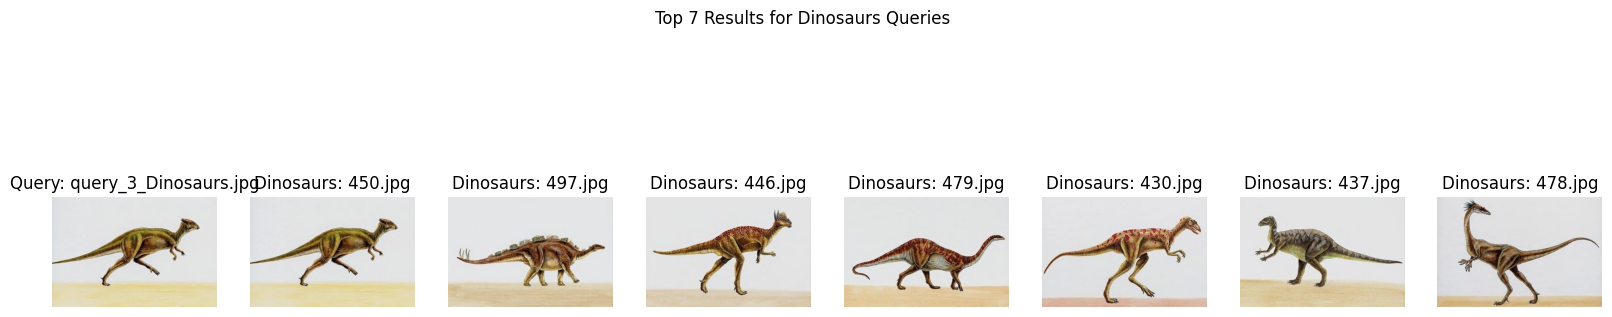

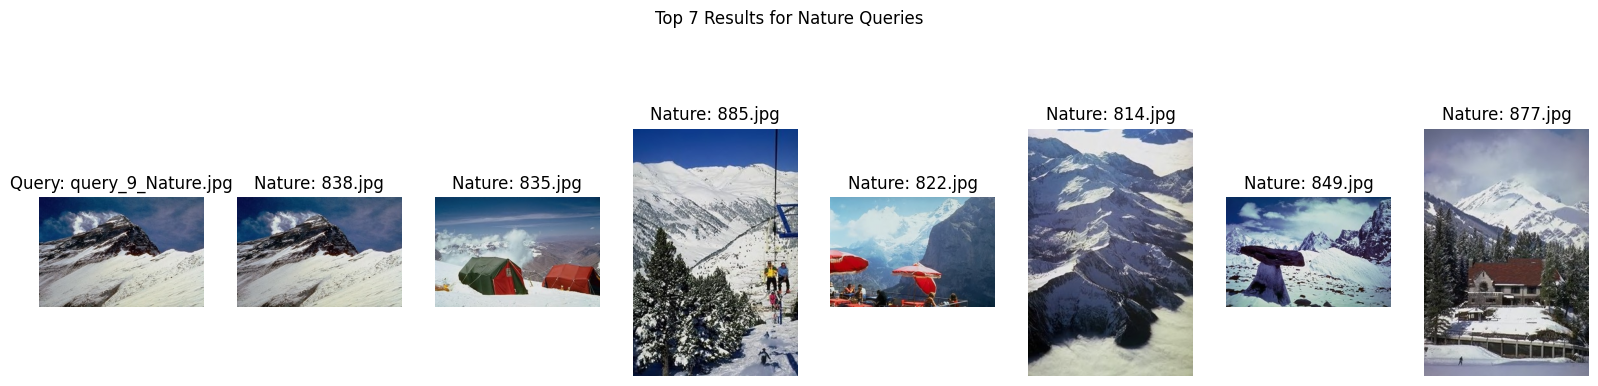

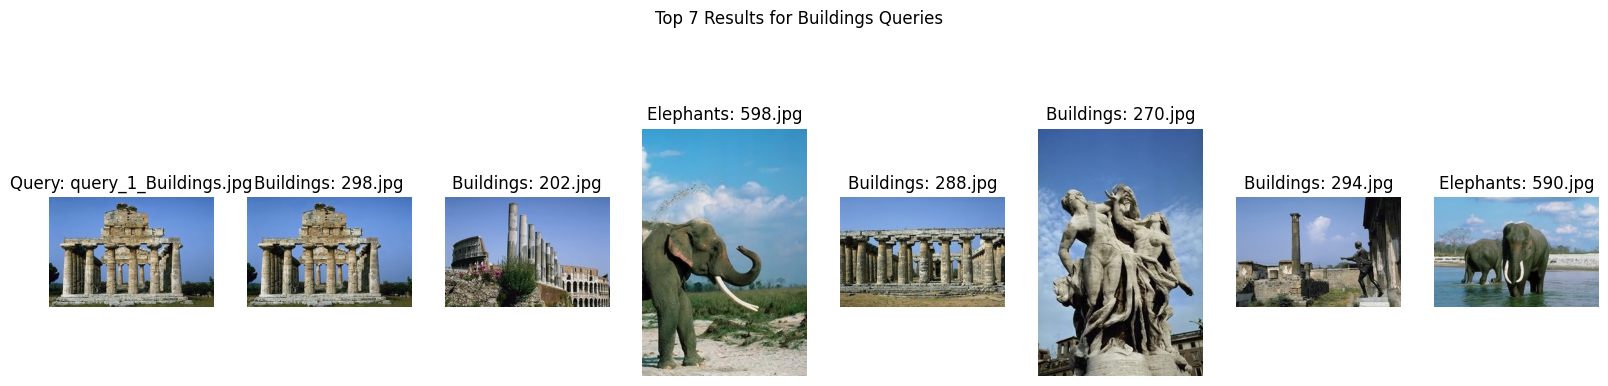

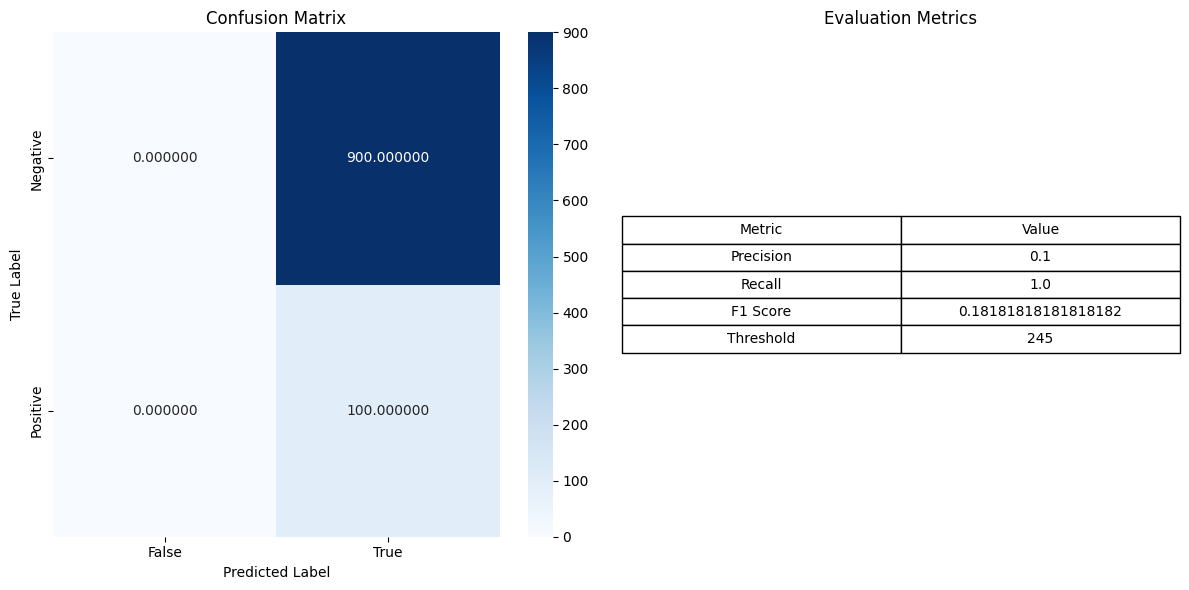

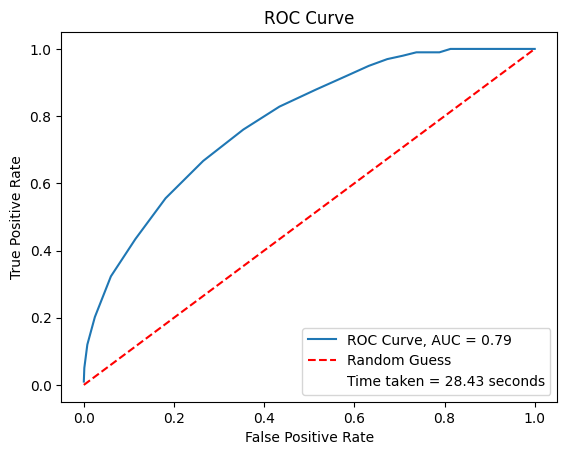

In [ ]:
more_featrues =  False
query_histograms = compute_query_histograms_moments(query_path, more_featrues)
category_histograms = compute_histograms_moments(dataset_path, more_featrues)
w = np.array([
    [0.2, 0.1, 0.7, 0, 0, 0],
    [0.2, 0.1, 0.7, 0, 0, 0],
    [0.2, 0.1, 0.7, 0, 0, 0]
]) if more_featrues else np.array([
    [1/3, 1/3, 1/3, 1, 1, 1],
    [1/3, 1/3, 1/3, 1, 1, 1],
    [1/3, 1/3, 1/3, 1, 1, 1]
])
start = time.time()
roc_curve_data = compute_roc_curve_moments(query_histograms, category_histograms, start, w)

Now when we added weights according to the importance of the moment, the AUC increased a little bit.

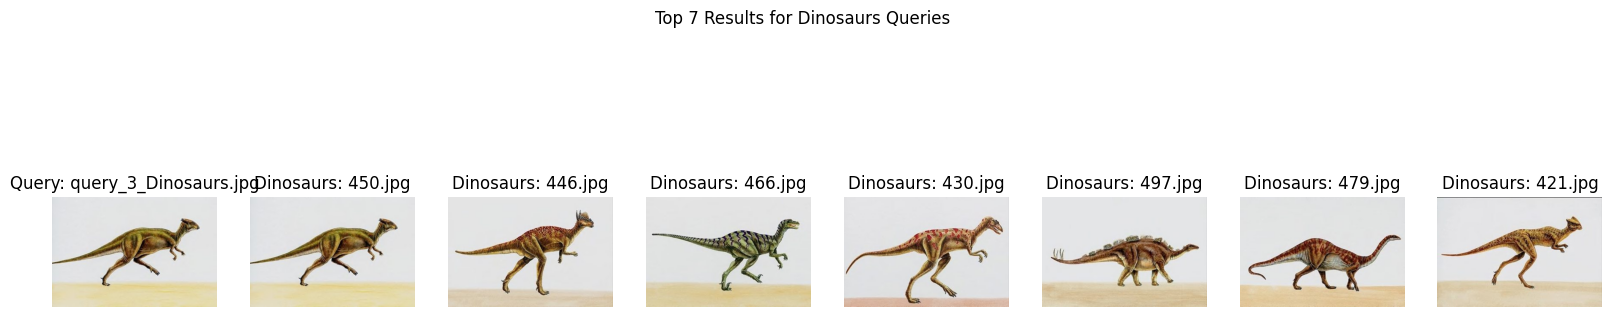

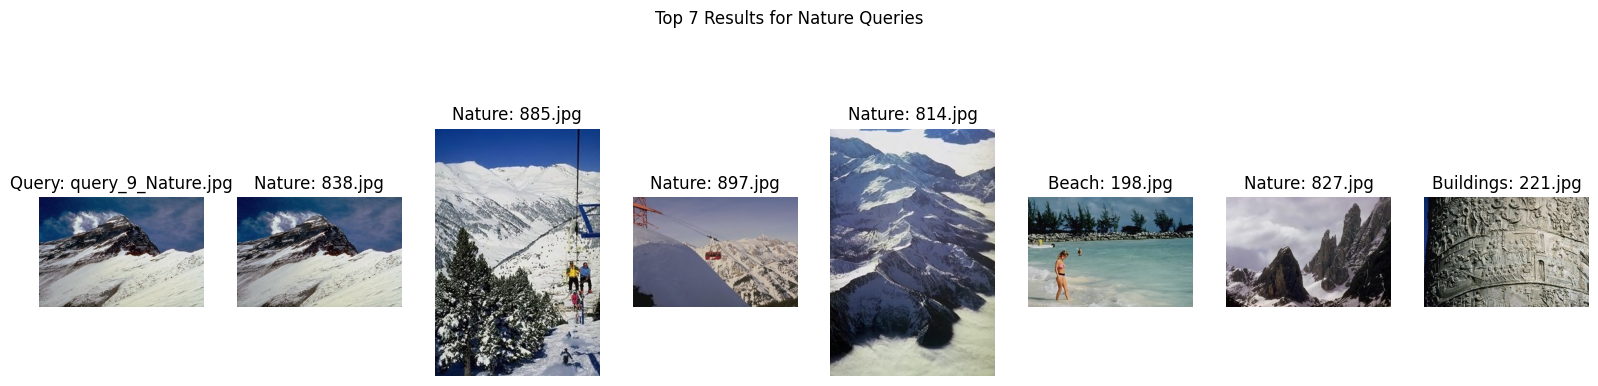

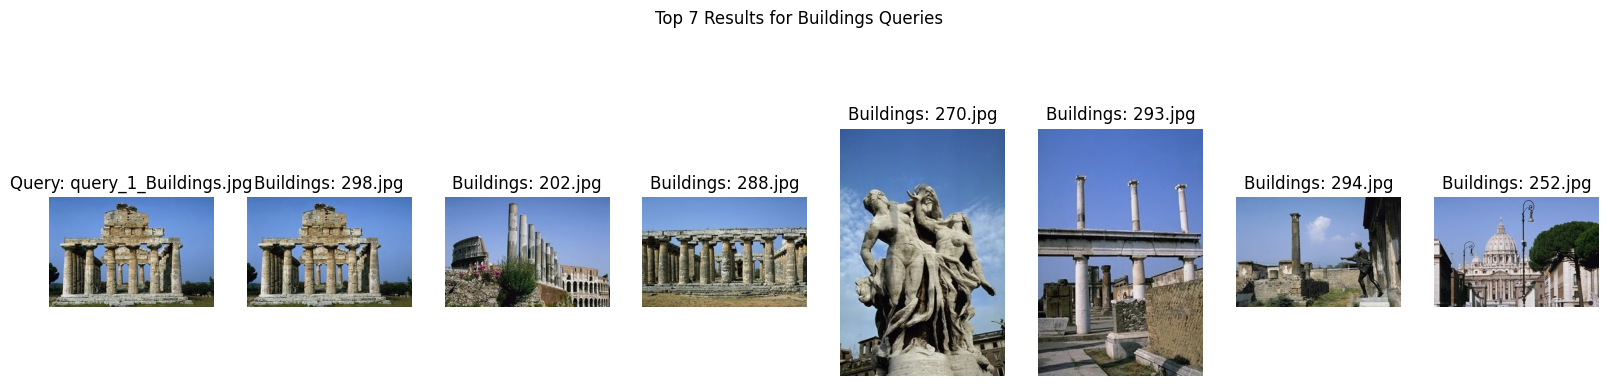

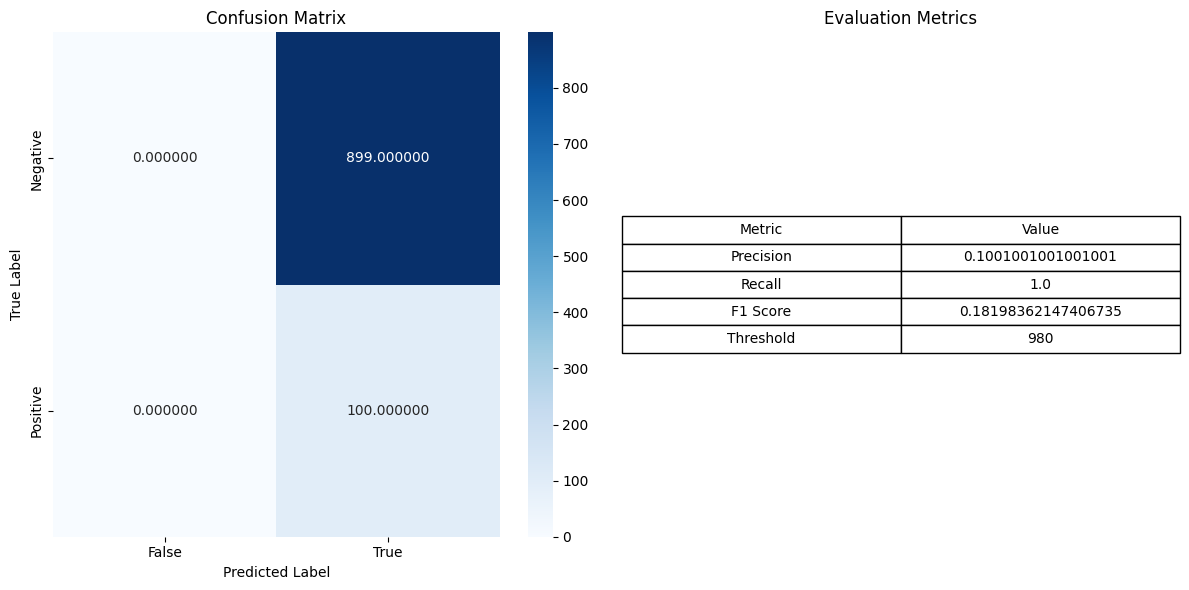

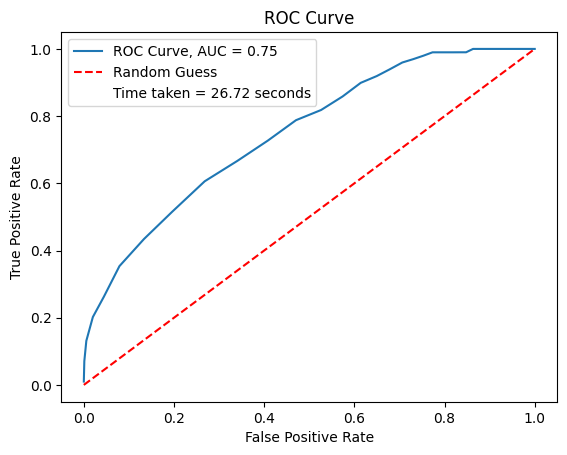

In [ ]:
more_featrues =  True
query_histograms = compute_query_histograms_moments(query_path, more_featrues)
category_histograms = compute_histograms_moments(dataset_path, more_featrues)
w = np.array([
    [1/3, 1/3, 1/3, 1, 1/4, 1][::-1],
    [1/3, 1/3, 1/3, 1, 1/4, 1][::-1],
    [1/3, 1/3, 1/3, 1, 1/4, 1][::-1]
]) if more_featrues else np.array([
    [1/3, 1/3, 1/3, 1, 1, 1],
    [1/3, 1/3, 1/3, 1, 1, 1],
    [1/3, 1/3, 1/3, 1, 1, 1]
])
start = time.time()
roc_curve_data = compute_roc_curve_moments(query_histograms, category_histograms, start, w)

When we added more features with weights, if the weights were assigned correctly it would have increased but here I tried a lot of weights and this was the best I could get.

# Task 3: Try to improve the performance of the CBIR system using other image representation techniques.

VGG16 is a deep convolutional neural network architecture that consists of 16 weight layers, including 13 convolutional layers and 3 fully connected layers.
The architecture is known for its simplicity, with small receptive fields and a stack of convolutional layers, making it effective for image feature extraction.

Source: https://github.com/ruizewang/CBIR-CNN/tree/master

This function performs matching between query images features and features of images in the dataset based on a given threshold. For each query we calculate all the distances between them and the dataset, where the distance is (1 - similarity) and the similarity is between 0 and 1. Highest similarity yields least distance, which yields higher ranking.

In [ ]:
def find_matches_below_threshold_upgrade(query_histograms, category_histograms, threshold):
    all_matches = {}
    for query_name, values in query_histograms.items():
        query_features = values['features']

        all_category_matches = []
        for image_name, values_data in category_histograms.items():
            data_features = values_data['features']
            category = values_data['category']
            distance = np.dot(query_features, data_features.T)
            similarity = round(similarity, 5)
            distance = 1 - similarity
            if distance <= threshold:
                all_category_matches.append({'category': category, 'image_name': image_name, 'distance': distance})
        all_matches[query_name] = sorted(all_category_matches, key=lambda x: x['distance'])

    return all_matches

This function is the same as the ones before, computes the points on the ROC curve by finding the matches below a certain threshold for the queries.

In [ ]:
def compute_roc_curve_upgrade(query_histograms, category_histograms, start):
    all_matches = {}
    true_positive_rates = []
    false_positive_rates = []
    iter = 0

    for threshold in np.arange(0, 1, 0.01):
        matches_below_threshold = find_matches_below_threshold_upgrade(query_histograms, category_histograms, threshold)
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0
        iter += 1

        for query_name, matches in matches_below_threshold.items():
            ground_truth_category = query_name.split('_')[-1].split('.')[0]
            predicted_categories = [match['category'] for match in matches]
            tp = 0
            for predicted_category in predicted_categories:
                if predicted_category == ground_truth_category:
                    tp += 1

            true_positives += tp
            false_positives += len(predicted_categories) - tp
            false_negatives += photos_per_category - tp
            true_negatives += len_dataset - (tp + len(predicted_categories) - tp + photos_per_category - tp)

        true_positives = true_positives // len_queries
        false_positives = false_positives // len_queries
        true_negatives = true_negatives // len_queries
        false_negatives = false_negatives // len_queries

        assert false_positives + true_negatives > 0
        assert true_positives + false_positives > 0
        assert true_positives + false_negatives > 0

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        assert precision + recall > 0
        F1_score = 2 * precision * recall / (precision + recall)
        TPR = recall
        FPR = false_positives / (false_positives + true_negatives)
        true_positive_rates.append(TPR)
        false_positive_rates.append(FPR)

        if iter == 60:
            categories_to_plot = ['Dinosaurs', 'Flowers', 'Horses']
            for query in os.listdir(query_path):
              category = query.split('_')[-1].split('.')[0]
              if category in categories_to_plot:
                plot_top_results(matches_below_threshold[query], query)

            # Confusion matrix data
            matrix_data = [[true_negatives, false_positives], [false_negatives, true_positives]]

            # Metrics data
            metrics_labels = ['Precision', 'Recall', 'F1 Score', 'Threshold']
            metrics_values = [precision, recall, F1_score, threshold]

            # Plotting confusion matrix and evaluation metrics as heatmaps
            plt.figure(figsize=(12, 6))

            # Confusion Matrix
            plt.subplot(1, 2, 1)
            class_labels = ['Negative', 'Positive']
            class_labels2 = ['False', 'True']
            sns.heatmap(matrix_data, annot=True, fmt="f", cmap="Blues", xticklabels=class_labels2, yticklabels=class_labels)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix')

            # Metrics Table
            plt.subplot(1, 2, 2)
            table_data = [[label, value] for label, value in zip(metrics_labels, metrics_values)]
            table = plt.table(cellText=table_data, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1.5)
            plt.axis('off')
            plt.title('Evaluation Metrics')

            plt.tight_layout()
            plt.show()

    roc_auc = auc(false_positive_rates, true_positive_rates)
    plt.plot(false_positive_rates, true_positive_rates, label=f'ROC Curve, AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    end = time.time()
    time_str = f'Time taken = {(end - start):.2f} seconds'
    plt.plot([], [], ' ', label=time_str)  # Create an empty plot for the time legend entry

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for Two Models')
    plt.legend()
    plt.show()

Initializing the VGG16 model.

In [ ]:
input_shape = (128, 128, 3)
weight = 'imagenet'
pooling = 'max'
model = VGG16(weights = weight, input_shape = (input_shape[0], input_shape[1], input_shape[2]), pooling = pooling, include_top = False)

This function takes an image path, loads and preprocesses the image, and then extracts features using the VGG16 model.

The obtained feature vector is normalized by dividing it by its L2 norm, ensuring that the features are on a unit hypersphere. This normalization aids in comparison and similarity calculations.

In [ ]:
def extract_feat(img_path):
    print(f'Extracring {img_path}')
    img = imaging.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img = imaging.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feat = model.predict(img)
    norm_feat = feat[0] / LA.norm(feat[0])
    return norm_feat

Extracting the features of the dataset.

In [ ]:
dataset_values = {}
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        features = extract_feat(image_path)
        dataset_values[image_name] = {'category': category, 'features': features}

Extracring /content/Dataset/Dinosaurs/467.jpg
1/1 [==============================] - 0s 353ms/step
Extracring /content/Dataset/Dinosaurs/456.jpg
1/1 [==============================] - 0s 186ms/step
Extracring /content/Dataset/Dinosaurs/483.jpg
1/1 [==============================] - 0s 185ms/step
Extracring /content/Dataset/Dinosaurs/439.jpg
1/1 [==============================] - 0s 182ms/step
Extracring /content/Dataset/Dinosaurs/492.jpg
1/1 [==============================] - 0s 177ms/step
Extracring /content/Dataset/Dinosaurs/460.jpg
1/1 [==============================] - 0s 173ms/step
Extracring /content/Dataset/Dinosaurs/465.jpg
1/1 [==============================] - 0s 185ms/step
Extracring /content/Dataset/Dinosaurs/480.jpg
1/1 [==============================] - 0s 176ms/step
Extracring /content/Dataset/Dinosaurs/452.jpg
1/1 [==============================] - 0s 174ms/step
Extracring /content/Dataset/Dinosaurs/424.jpg
1/1 [==============================] - 0s 188ms/step
Extracring

Extracting the features of the queries.

In [ ]:
query_values = {}
for query_name in os.listdir(query_path):
    query_image_path = os.path.join(query_path, query_name)
    features = extract_feat(query_image_path)
    query_values[query_name] = {'features': features}

Extracring /content/Queries/query_3_Dinosaurs.jpg
1/1 [==============================] - 0s 186ms/step
Extracring /content/Queries/query_8_Humans.jpg
1/1 [==============================] - 0s 178ms/step
Extracring /content/Queries/query_5_Flowers.jpg
1/1 [==============================] - 0s 180ms/step
Extracring /content/Queries/query_7_Horses.jpg
1/1 [==============================] - 0s 177ms/step
Extracring /content/Queries/query_9_Nature.jpg
1/1 [==============================] - 0s 194ms/step
Extracring /content/Queries/query_6_Food.jpg
1/1 [==============================] - 0s 184ms/step
Extracring /content/Queries/query_1_Buildings.jpg
1/1 [==============================] - 0s 179ms/step
Extracring /content/Queries/query_4_Elephants.jpg
1/1 [==============================] - 0s 181ms/step
Extracring /content/Queries/query_2_Buses.jpg
1/1 [==============================] - 0s 176ms/step
Extracring /content/Queries/query_0_Beach.jpg
1/1 [==============================] - 0s 177ms

Saving the model

In [ ]:
model_save_path = 'vgg16_model.h5'
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting the results

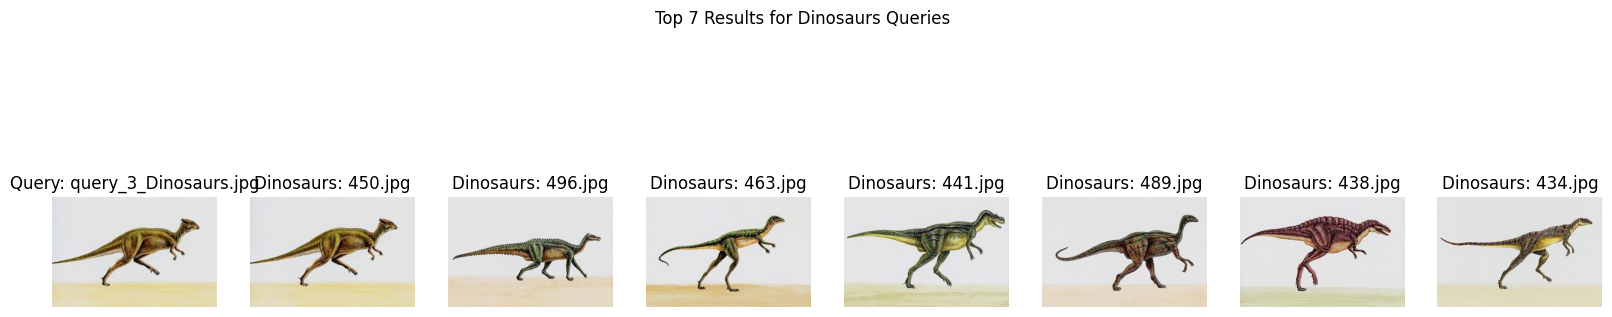

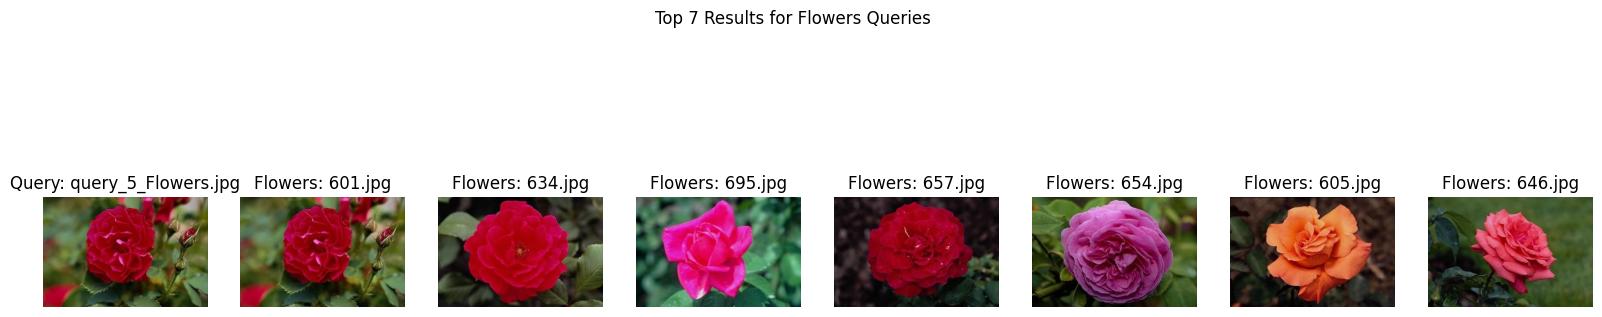

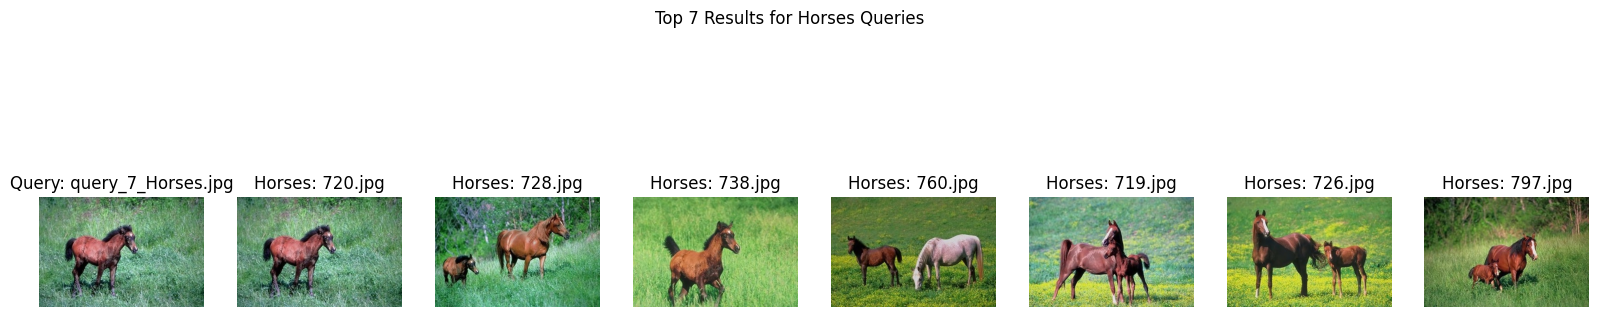

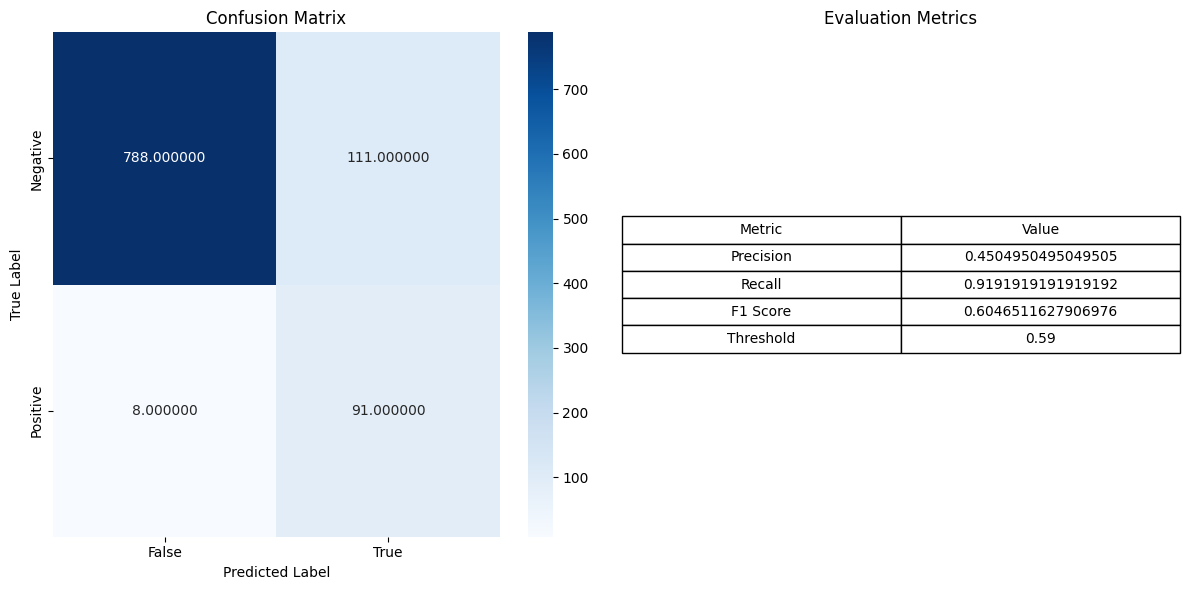

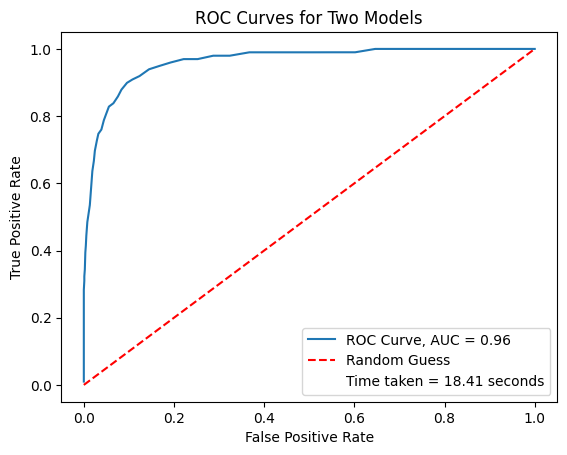

In [ ]:
start = time.time()
compute_roc_curve_upgrade(query_values, dataset_values, start)

We can see the incredible performance of this model, with retrieving a lot of correct categories and a high AUC for the ROC curve.

* Precision: VGG16 demonstrates a notable improvement in precision (0.45) compared to Color Histogram (0.15) and Color Moments (0.12), indicating a better ability to avoid false positives.

* Recall: VGG16 achieves a recall of 0.91, comparable to Color Moments (0.98) but higher than Color Histogram (0.76), suggesting good retrieval of relevant images.

* F1-score: VGG16's F1-score of 0.60 is significantly higher than both Color Histogram (0.26) and Color Moments (0.22), representing a more balanced performance between precision and recall.

* AUC: VGG16 excels with a remarkable AUC of 0.96, far surpassing both Color Histogram (0.71-0.73) and Color Moments (0.78), indicating superior discrimination between relevant and irrelevant images.

VGG16 emerges as the strongest performer across all metrics, demonstrating its ability to capture more complex and discriminative image features. The exceptionally high AUC for VGG16 highlights its exceptional ability to distinguish between relevant and irrelevant images, making it a promising choice for various CBIR tasks.

# **Conclusion**


This project tested 3 ways to search for similar images based on their content: color patterns, color moments, and a deep learning model called VGG16.

# Key Findings and Achievements

- VGG16 outperforms traditional color features: Across all metrics (precision, recall, F1-score, and AUC), VGG16 demonstrated superior performance. Its ability to capture complex image features led to significantly higher precision and overall discrimination between relevant and irrelevant images.

- Color moments achieve high recall but suffer from low precision: While Color Moments excelled in retrieving a high proportion of relevant images (recall), it struggled with false positives (low precision). This suggests its application might be beneficial when recall is prioritized over minimizing false positives.

- Color histograms offer a balanced but less effective approach: Compared to VGG16 and Color Moments, Color Histograms presented a moderate performance across all metrics. While offering a balance between precision and recall, their overall effectiveness remained inferior to the other methods.

# Overall Effectiveness of Color Features

While color features (histograms and moments) proved useful for CBIR tasks, their limitations compared to deep learning models became evident. Their reliance on simple color statistics leads to lower discriminatory power and difficulty in capturing complex image relationships. However, they offer advantages in terms of computational efficiency and transparency, making them potentially suitable for certain applications or as part of hybrid approaches.

# Insights and Recommendations for Further Research

- Deep learning holds significant promise for CBIR: The remarkable performance of VGG16 highlights the potential of deep learning models for image retrieval tasks. Exploring other deep learning architectures and feature extraction techniques can further enhance performance and address specific domain requirements.

- Hybrid approaches hold potential: Combining deep learning with color features or other methods might leverage the strengths of each approach to improve overall performance or address specific limitations. For example, color features could be used for pre-filtering large datasets before applying deep learning for finer discrimination.